<h2>Week 12 - models building</h2>

* Group name: Bloodhounds
* Batch code: LISUM09
* Specialization: Data science
* Group member details:
* Margarita Prokhorovich, marusya15071240@gmail.com, Thailand

In this document, we perform data cleansing and transformation techniques first, to prepare the data for model building, aftr that explore different models and compare their predictive power. Also we're going to explore different options, e.g. different hyperparameters, use models with/without removing outliers, use models with different sets of features, etc.

First things first, we need to read a file and create a dataframe, as usual.

In [1]:
#reading the dataframe
import pandas as pd
df = pd.read_csv('bank-additional-full.csv', delimiter = ';')
print(df.shape)

df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Let's look at the dataframe info one more time. 

In [238]:
#display the info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

As we remember, all the data types in the dataframe are correct. However, there are some other issues in the data that we need to eliminate. We will use data cleansing and transformation approaches from the previous project part: will drop the duplicates, transform pdays category, fill unknown values using KNN approach (the fourth one). As for outliers, we prefer to keep them on this stage because removing the outliers can prevent us from identifying patterns in the data more clearly. 

We decided to create pdays_categ feature with labels 'yes' and 'no' because it's easier to process this feature with other categorical features.

In [2]:
#find duplicates and display their quantity
n_duplicates = df.duplicated().sum()
print(f"Number of duplicates - {n_duplicates}.")

#delete all the full duplicates. We can see decreasing in a rows number
df = df.drop_duplicates()
df.shape

Number of duplicates - 12.


(41176, 21)

In [3]:
print(f'\nNumber of examples where a client was not previously contacted - {len(df[df.pdays == 999])}, percentage - {round(len(df[df.pdays == 999])/len(df) * 100,2)}%.')
df['pdays_categ'] = ['no' if pday == 999 else 'yes' for pday in df.pdays]
df = df.drop(['pdays'], axis = 1)


Number of examples where a client was not previously contacted - 39661, percentage - 96.32%.


In [4]:
#create an empty df where new filled columns will be stored
df_final_knn = pd.DataFrame()

#define a function that predicts unknown values
def fill_unknown_knn(column_name):   
   try: 
      #import necessary modules
      from sklearn.model_selection import train_test_split
      from sklearn.utils.class_weight import compute_class_weight
      from sklearn import preprocessing
      from sklearn.preprocessing import LabelEncoder
      from sklearn.neighbors import KNeighborsClassifier
      from IPython.display import display
      import numpy as np

      #copy df
      df_copy = df.copy()

      #exclude binary features from categories
      global categories 
      categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
      categories = [i for i in categories if i not in [column_name, 'y', 'contact']]

      #transform another categorical features to dummy variables
      deleted_columns = []
      for i in categories:
         dummies_x = pd.get_dummies(df[i])
         deleted_columns.append(dummies_x.columns[0])
         df_copy = pd.concat([df_copy,dummies_x],axis='columns')

      #use label encoder
      le = LabelEncoder()
      #transform binary features - contact and y
      df_copy.contact = le.fit_transform(df_copy.contact)
      df_copy.y = le.fit_transform(df_copy.y)

      #delete columns - text categorical features and one from each encoded variables
      df_copy.drop(categories, axis = 1, inplace = True)
      df_copy.drop(deleted_columns, axis = 1, inplace = True)

      #split the dataframe to train set - without unknown variables and test - with unknown variables
      df_copy_train = df_copy[df_copy.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_copy_test = df_copy[df_copy.loc[:, (column_name)] == 'unknown']
      #encode output variables
      df_copy_train['new_col'] = le.fit_transform(df_copy_train.loc[:, (column_name)])
      #assign a new column to y and drop  the column after that
      y = df_copy_train['new_col']
      df_copy_train.drop('new_col', axis = 1, inplace = True)

      #remove job column from train and test sets
      df_copy_train = df_copy_train.drop([column_name], axis='columns')
      df_copy_test = df_copy_test.drop([column_name], axis='columns')

      #Creating a model 
      #normalize data and split train set into train and validation sets
      scaler = preprocessing.StandardScaler().fit(df_copy_train)
      X_scaled = scaler.transform(df_copy_train)
      X_train, X_val, y_train, y_val = train_test_split(X_scaled,y,train_size=0.3)

      #training the model
      knn = KNeighborsClassifier(n_neighbors=10)
      knn.fit(X_train, y_train)
      knn.predict(X_val)
      print(f'Model accuracy for {column_name} is {round(knn.score(X_val, y_val) * 100, 2)} %.')

      #save the model
      # filename = 'model.pkl'
      # pickle.dump(model, open(filename, 'wb'))

      #load the model
      #pickled_model = pickle.load(open(filename, 'rb'))

      #normalize X test data
      scaler_test = preprocessing.StandardScaler().fit(df_copy_test)
      X_test_scaled = scaler_test.transform(df_copy_test)

      #predict unknown values
      prediction = knn.predict(X_test_scaled)

      #convert numbers to labels and create pd series
      df_copy_test[column_name] = le.inverse_transform(prediction)
      df_copy_test = df_copy_test[column_name].reset_index()
      df_copy_test = df_copy_test.set_index('index')

      #create a new dataframe and fill unknown values from created dataframe
      df_1 = df[df.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_2 = df[df.loc[:, (column_name)] == 'unknown'].copy(deep = True)

      #assign pd series to a dataframe column and merge the dataframes
      df_2[column_name] = df_copy_test
      series_final = df_1.append(df_2)[column_name]
      global df_final_knn
      df_final_knn = pd.concat([df_final_knn,series_final],axis='columns')
      return df_final_knn
   except Exception as err:
      print('Since "default" feature has a little "yes" values, sometimes they are all concentrated in a cross-validation set. Please rerun the script one more time.') 
      return err

#apply the function to columns with unknown values
for i in ['job', 'marital', 'education', 'housing', 'loan', 'default']:
     df_fill = fill_unknown_knn(i)

new_cols = [df_fill[i] for i in df_fill.columns if i != 'default']
#assign new filled columns to the old ones in the dataframe
for i,y in zip(new_cols, df_fill.columns):
  df[y] = i

#check that there's no any unknown values in these columns anymore
print('Number of "unknown" occurrences:')
for i in df.columns:
    if 'unknown' in set(df[i]):
        print("- feature - ", i, ", number - ", len(df[df[i] == 'unknown']), ", percentage -", round(len(df[df[i] == 'unknown'])/df.shape[0]*100,4), "%")

Model accuracy for job is 46.99 %.
Model accuracy for marital is 62.45 %.
Model accuracy for education is 47.89 %.
Model accuracy for housing is 50.77 %.
Model accuracy for loan is 84.39 %.
Model accuracy for default is 100.0 %.
Number of "unknown" occurrences:
- feature -  default , number -  8596 , percentage - 20.8762 %


It's worth noting that when using KNN algorithm, we treated all the categorical variables as nominal ones. However, as for education feature, in fact it's ordinal one, i.e., has certain gradation from lower to higher education level. We encoded this feature as a nominal one because it had an 'unknown' class, so, we couldn't classify it as lower or higher level, also, the model performed better with education encoded as a nominal feature. In next steps we will stick to treating this variable as an ordinal.

Moreover, we could consider one more technique for handling skewed distributions. In the previous week project part we tried to use log function. We can also try to use binning. Using binning can help us to make distributions smoother. We can consider using binned features in models building.

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays_categ,age_bin,duration_bin,campaign_bin,previous_bin,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,no,"(49.4, 57.5]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,no,"(49.4, 57.5]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,no,"(33.2, 41.3]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,no,"(33.2, 41.3]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,no,"(49.4, 57.5]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"


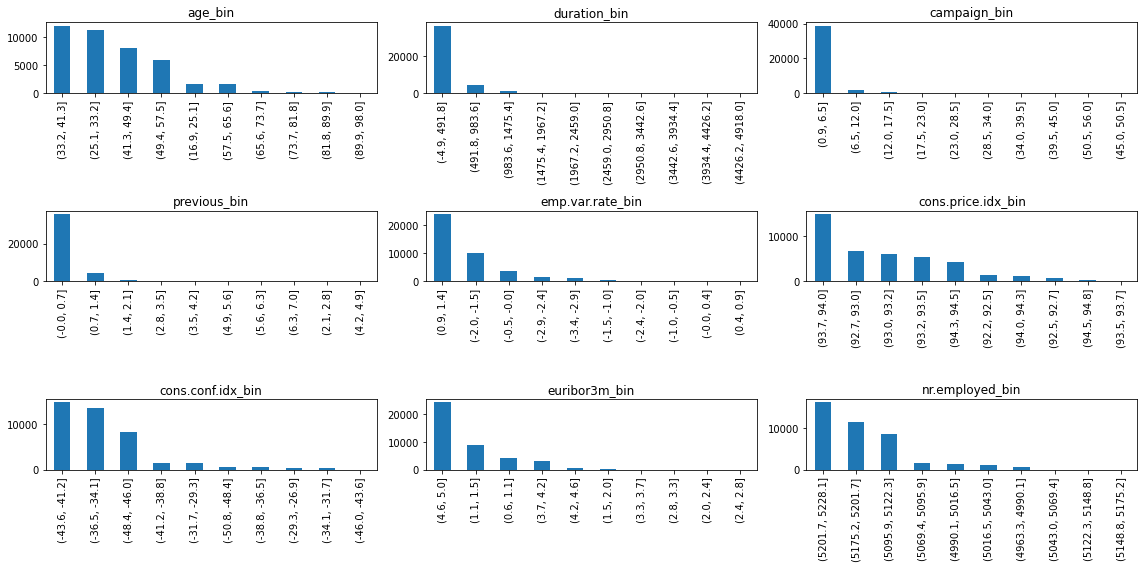

In [272]:
import matplotlib.pyplot as plt
#set a list of numeric variables
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)
#create a copy of the dataframe
df_cut = df.copy()
#set a number of bins
bins = 10
#bin each column and plot it
for i in numeric:
    _, edges = pd.cut(df_cut[i], bins=bins, retbins=True)
    labels = [f'({edges[b]:.1f}, {edges[b+1]:.1f}]' for b in range(bins)]
    df_cut[i +'_bin'] = pd.cut(df_cut[i], bins=bins, labels=labels, ordered=False)
display(df_cut.head(5))

binned = [i for i in df_cut.columns if 'bin' in i]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize = (16,8))
for i, ax, title in zip(binned,axs.reshape(-1), binned):
    df_cut[i].value_counts().plot(kind = 'bar', ax = ax)
    ax.title.set_text(title)
fig.tight_layout()
plt.show()

We can see that in comparison to initial condition, the distributions became smoother.

Finally, considering outliers, we decided to use z-score as initial option to avoid possible overfitting, i.e., reduce the variance in the data. Also, we plan to normalize the data using scallers, which are quite sensitive to the presence of outliers.

In [5]:
#removing outliers
from scipy import stats
import numpy as np
columns = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

list_of_indexes = []
for i in columns:
    z = np.abs(stats.zscore(df[i]))
    to_del = (np.where(z > 3))
    print(f'Need to remove {len(to_del[0])} outliers from {i} feature.')
    list_of_indexes.extend(to_del[0].tolist())
print(f'Number of examples to be deleted - {len(set(list_of_indexes))}.')
delete = set(list_of_indexes)
df.drop(delete, axis=0, inplace=True)
print(f'Number of examples after outliers removal - {df.shape}')

Need to remove 369 outliers from age feature.
Need to remove 861 outliers from duration feature.
Need to remove 869 outliers from campaign feature.
Need to remove 1064 outliers from previous feature.
Need to remove 0 outliers from emp.var.rate feature.
Need to remove 0 outliers from cons.price.idx feature.
Need to remove 0 outliers from cons.conf.idx feature.
Need to remove 0 outliers from euribor3m feature.
Need to remove 0 outliers from nr.employed feature.
Number of examples to be deleted - 3065.
Number of examples after outliers removal - (38111, 21)


To this moment, we prepared the data for further analysis in a following way:
- removed duplicates;
- removed outliers with z-score;
- converted pdays feature to a categorical feature;
- filled 'unknown' values using K nearest neighbours algorithm;
- considered possible transformation of numeric features - binning.

Next step is to handle a dataset imbalance problem. As we already saw, the dataset is imbalanced, since share of positive answers is much less.

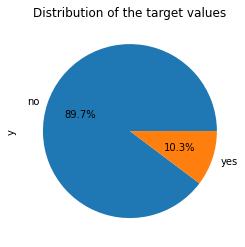

In [45]:
#create a pie plot
df.y.value_counts(normalize = True).plot(kind='pie', y = 'y', autopct='%1.1f%%', title = 'Distribution of the target values');

We don't plan to consider techniques such as undersampling a majority class, since it causes a significant decrease in number of examples and a loss of valuable information. 
We will separate test set for final validation (20% of the dataset) and will work with the rest of the data as training data (80%).

Also we will encode all the features and scale them.
Encoding is necessary because models cannot handle non-numeric data. For categorical fatures we will use get_dummies method, i.e. apply One-Hot-Encoding. Also we need to remove one column from each generated dummies set to avoid a Dummy Variable Trap. Only for education feature we will use Label encoding, since this feature can be considered as ordinal one.

We need to scale features because some of the models we will consider are sensitive to features scale. We will use MinMax scaller.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
categories = df.select_dtypes(include = 'object')
categories = [i for i in categories if i not in ['y', 'education']]

deleted_columns = []
list_of_education = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']

#encode education as an ordinal feature
df['education'] = df.education.replace(to_replace = list_of_education, value = list(range(len(list_of_education))))

#one-hot-encoding
for i in categories:
        dummies_x = pd.get_dummies(df[i])
        deleted_columns.append(dummies_x.columns[0])
        df = pd.concat([df,dummies_x],axis='columns')
df.drop(categories, axis = 1, inplace = True)
df.drop(deleted_columns, axis = 1, inplace = True)
#creating new columns with dummy features
df.columns = ['age', 'education', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y',
       'job1', 'job2', 'job3', 'job4', 'job5',
       'job6', 'job7', 'job8', 'job9', 'job10',
       'marry1', 'marry2', 'default1',
       'default2', 'housing', 'loan', 'contact', 'month1', 'month2', 'month3', 'month4', 'month5',
       'month6', 'month7', 'month8', 'month9', 'day_week1', 'day_week2', 'day_week3', 'day_week4', 'poutcome1',
       'poutcome2', 'pdays_categ']

#encoding a target feature
le = LabelEncoder()
df['y'] = le.fit_transform(df['y'])
#define input and output
y = df.y
X = df.loc[:, df.columns != 'y']
#perform train-test split. We will work with 80% of initial dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify = y)

After the splitting we should check that ratio between target classes are kept. We can see that shares of positive and negative answers are equal in train and test sets.

In [190]:
print('Y train distribution')
print(y_train.value_counts(normalize = True))
print('\nY test distribution')
print(y_test.value_counts(normalize = True))

Y train distribution
0    0.887341
1    0.112659
Name: y, dtype: float64

Y test distribution
0    0.887324
1    0.112676
Name: y, dtype: float64


Next step is to oversample a minority class. For this purpose we use SMOTE method.
Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model. In SMOTE new instances are synthesized from the existing data. If we explain it in simple words, SMOTE looks into minority class instances and use k nearest neighbor to select a random nearest neighbor, and a synthetic instance is created randomly in feature space.

In [7]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(X_train, y_train)
#oversampled = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)
oversampled_Y.value_counts(normalize = True)

0    0.5
1    0.5
Name: y, dtype: float64

Let's check the classes ratio again. We can see that now the shares are equal. We should note that this technique is used only for training data.

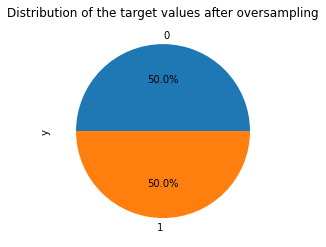

In [49]:
#create a pie plot
oversampled_Y.value_counts(normalize = True).plot(kind='pie', y = 'y', autopct='%1.1f%%', title = 'Distribution of the target values after oversampling');

Generally, we will try to use the approach mentioned to handle the imbalance in our data. Also we will consider assigning class weights, e.g. in Logistic regression.

Before normalization, we should decide which features we should remove because after scalling the data is converted to numpy array. We consider the following options:
- remove numeric features euribor3m and emp.var.rate, since the analysis showed that these features have the highest multicollinearuty with another features and it can affect bias in the models;
- consider model with and without categorical features: housing, month, loan, day of week, default;
- consider model with and without duration feature. Duration feature is not recommended as this will be difficult to explain the result to business and also it will be difficult for business to campaign based on duration.

We will consider features tuning by building only one model to reduce processing time. We assume that if set of remaining features will perform well on one basic model, this set of features will be appropriate for another models. The main model to consider is Logistic regression because this type of model is the most popular for solving binary classification problems.

After that we will explore the rest of the supervised learning models to compare the performance. Finally, we will build a neural network as a benchmark and explore, how deep learning handles with the dataset.

We will normalize the oversampled data using MinMax scaller. As for one-hot-encoded features, requirements are different for different models. Nevertheless, MinMax scaller keeps binary features unchanged, i.e. in range [0,1] while StandartScaller transforms them and with this transformation models perform worse.

In [50]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

absent_features = {}
#define function that returns model score without a certain set of features
def without_features(feature_list = None, delete_cols = None):
    #considering with/without housing, month, loan, day of week - features, that have the least impact according to chi-square test
    #creating a copy of a current data set
    X_least_chi = oversampled_X.copy()
    #drop columns with multicollinearity
    X_least_chi.drop(['euribor3m', 'emp.var.rate'], axis = 1, inplace = True)
    #copt the test set and drop the same columns
    X_test_chi = X_test.copy()
    X_test_chi.drop(['euribor3m', 'emp.var.rate'], axis = 1, inplace = True)
    #define columns we want to drop and drop them 
    if feature_list != None:
        X_least_chi = X_least_chi.drop(delete_cols, axis = 1)
        X_test_chi = X_test_chi.drop(delete_cols, axis = 1)
    #apply scalling after removal
    scaler_train = MinMaxScaler().fit(X_least_chi)
    X_least_chi_sc = scaler_train.transform(X_least_chi)
    scaler_test = MinMaxScaler().fit(X_test_chi)
    X_test_chi_sc = scaler_test.transform(X_test_chi)

    #build Logistic regression
    model = LogisticRegression(max_iter = 200)
    model.fit(X_least_chi_sc, oversampled_Y)
    model.predict(X_test_chi_sc)
    #write the result to a dictionary
    if feature_list != None:
        absent_features[', '.join(feature_list)] = (round(model.score(X_test_sc,y_test),3))
    else:
        absent_features['with all features'] = (round(model.score(X_test_sc,y_test),3))

#apply the function with different combinations
without_features(['duration', 'housing', 'month', 'day_week', 'loan', 'default'], ['duration', 'housing', 'month1', 'month2', 'month3', 'month4', 'month5', 'month6',
       'month7', 'month8', 'month9', 'day_week1', 'day_week2', 'day_week3',
       'day_week4', 'loan', 'default1', 'default2'])
without_features(['duration', 'housing', 'day_week', 'loan', 'default'], ['duration', 'housing', 'day_week1', 'day_week2', 'day_week3',
       'day_week4', 'loan', 'default1', 'default2'])
without_features(['duration', 'day_week', 'loan', 'default'], ['duration', 'day_week1', 'day_week2', 'day_week3',
       'day_week4', 'loan', 'default1', 'default2'])
without_features(['duration', 'loan', 'default'], ['duration', 'loan', 'default1', 'default2'])
without_features(['duration', 'default'], ['duration', 'default1', 'default2'])
without_features(['duration'], ['duration'])
without_features(['month', 'duration'], ['month1', 'month2', 'month3', 'month4', 'month5', 'month6',
       'month7', 'month8', 'month9', 'duration'])
without_features()

#create a dataframe with summary
feature_selection = pd.DataFrame(absent_features.items(), columns = ['model_without', 'score'])
feature_selection.sort_values(by = 'score')

,model_without,score
0,"duration, housing, month, day_week, loan, default",0.827
6,"month, duration",0.846
1,"duration, housing, day_week, loan, default",0.852
2,"duration, day_week, loan, default",0.856
4,"duration, default",0.860
3,"duration, loan, default",0.861
5,duration,0.862
7,with all features,0.881


We can see that the model with all features has accuracy about 88%. Month and duration features have the biggest impact on the model score and without them the score decreases by around 4%. As for the other features, they don't affect the result signifficantly and removing them don't influence the final result much. 
That's why next step is to remove all the unwanted features. We also remove duration because we plan our final model not to include this feature that is hard to interpret. Nevertheless, we will consider a model with duration as an additional option later.

In [8]:
#remove all the unwanted features from train and test sets
oversampled_X = oversampled_X.drop(['euribor3m', 'emp.var.rate', 'duration', 'housing', 'day_week1', 'day_week2', 'day_week3',
       'day_week4', 'loan', 'default1', 'default2'], axis = 1)
X_test = X_test.drop(['euribor3m', 'emp.var.rate', 'duration', 'housing', 'day_week1', 'day_week2', 'day_week3',
      'day_week4', 'loan', 'default1', 'default2'], axis = 1)

#apply features scalling
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler().fit(oversampled_X)
oversampled_X_sc = oversampled_X.copy()
oversampled_X_sc[oversampled_X_sc.columns] = scaler_train.fit_transform(oversampled_X[oversampled_X.columns])
X_test_sc = X_test.copy()
scaler_test = MinMaxScaler().fit(X_test)
X_test_sc[X_test_sc.columns] = scaler_test.transform(X_test_sc[X_test_sc.columns])

<h3>Models selection</h3>

Now it's time to build several different models. We consider Support Vector Classifier, Random Forest, Logistic Regression, Decision Tree and K Nearest Neighbours. We plan to compare their performance and choose the best result measured as accoracy. Moreover, we make hyperparameter tuning using Grid search. It will help us to choose the best parameters for each model. We don't use a large range of hyperparameters possible values since in combination with multiple iterations of cross validation process (we use it for receiving more stable results here) takes a lot of time.

In [10]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

#define a dictionary that keeps models and corresponding parameters
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [5, 10, 15],
            'kernel': ['rbf']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [50, 70, 100, 120, 150]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'C': [0.1, 1,5, 10, 20, 50, 100]
        }
    },
    'des_tree': {
    'model': DecisionTreeClassifier(),
    'params' : {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best','random']
        }  
    },
    'knn': {
    'model': KNeighborsClassifier(),
    'params' : {
        'n_neighbors': [1,5, 10, 20, 50, 100]
        }
    }
}

from sklearn.model_selection import GridSearchCV
scores = []

#iterating through the dictionary, fit a model, calculate a score and append the result to the list
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False)
    print(f'fitting {model_name}...')
    clf.fit(oversampled_X_sc, oversampled_Y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
#create a dataframe with the results    
df_cross_scores = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df_cross_scores.sort_values(by = 'best_score', ascending = False)

fitting svm...
fitting random_forest...
fitting logistic_regression...
fitting des_tree...
fitting knn...


,model,best_score,best_params
1,random_forest,0.886816,{'n_estimators': 100}
4,knn,0.884678,{'n_neighbors': 10}
0,svm,0.872543,"{'C': 15, 'kernel': 'rbf'}"
3,des_tree,0.870934,"{'criterion': 'gini', 'splitter': 'random'}"
2,logistic_regression,0.864099,{'C': 100}


According to the results, Random Forest model performs the best on our preprocessed training set and gives accuracy about 88,5%. KNN classifier shows almost the same result.
The other models perform a little bit worse. Currently, we consider Random Forest Classifier with 100 estimators as the best option to apply.

Let's check it on our test set.

In [225]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(oversampled_X_sc, oversampled_Y)
model.score(X_test_sc, y_test)

0.8534697625606716

So, on the test set Random Forest gives about 85,3% accuracy.

<h3>Naive Bayes</h3>

Next, we will consider Naive Bayes. Since there are numeric and categorical features in the dataset, we will apply CategoricalNB for categorical variables and GaussianNB for numeric features. After that, we calculate log probabilities for both data types, calculate a final log probability by adding them up and substracting predictor prior probability.
For x which contains both categorical and continuous:
P(a|x) = log likelihood from categorical model + log likelihood from continuous model - log prior of class a.

In [224]:
#defining columns
cat_cols = ['education', 'campaign', 'job1', 'job2', 'job3', 'job4', 'job5', 'job6', 'job7', 'job8', 'job9', 'job10',
       'marry1', 'marry2', 'contact', 'month1', 'month2', 'month3', 'month4',
       'month5', 'month6', 'month7', 'month8', 'month9', 'poutcome1', 'poutcome2', 'pdays_categ']
cont_cols = ['age', 'campaign', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

from sklearn.naive_bayes import GaussianNB,CategoricalNB
gc = GaussianNB()
cont_classifier = gc.fit(oversampled_X_sc[cont_cols],oversampled_Y)

Cc = CategoricalNB()
mod = Cc.fit(oversampled_X_sc[cat_cols],oversampled_Y)

#jll - sum of log probability of continuous and categorical data
log_prior = mod.class_log_prior_
jlls = []
jlls.append(cont_classifier._joint_log_likelihood(X_test_sc[cont_cols]))
jlls.append(mod._joint_log_likelihood(np.array(X_test_sc[cat_cols].astype(int))))
jlls = np.hstack([jlls])
jll = jlls.sum(axis=0)
jlls = jlls - log_prior

#Standardising the results
fo = np.exp(jll)
sumso = np.sum(fo, axis = 1, keepdims = True) 
result = fo/sumso

#Output calculation
y_pred = np.argmax(result,axis=1)

#calculate the accuracy
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8030958940049849

We tested Naive Bayes on our test set and can see that accuracy is about 80% that is less than the Random Forest model provides.

Next. we will consider several additional options:
1. Neural network;
2. Logistic Regression with class weights (instead of oversampling the minority class);
3. Random Forest with binned and encoded numeric features;
4. Random Forest with duration.

<h3>Neural Network</h3>

As a benchmark, we will build a simple neural network with one input layer, where layer size is equal to number of features and an output layer with sigmoid activation function.

In [227]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=32))      
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(oversampled_X_sc, oversampled_Y, epochs=1, batch_size=40, validation_split=0.2)
predict_x=model.predict(X_test) 
y_pred = np.argmax(predict_x,axis=1)
print(accuracy_score(y_test, y_pred))

1095/1095 [==============================] - 4s 3ms/step - loss: 0.4141 - accuracy: 0.8221 - val_loss: 0.3751 - val_accuracy: 0.8213
0.89728453364817


We can see that a simple neural network without any hidden layers permorms better than our Random Forest model. Nevertheless, we will choose the last one because it is much easier to interpret.

<h3>Logistic Regression with class weights</h3>

Next, we will apply Logistic Regression with class weights. This technique is alternative for oversampling the class with positive answers in 'y' feature.

In [244]:
#compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y), y = y)
weight = {key: value for (key, value) in zip(np.unique(y), class_weights)}

weight

{0: 0.5572109480086554, 1: 4.8697929976999745}

In [249]:
#remove all the unwanted features from train and test sets
#we shouldn't use oversampled X features here
X_train_lr = X_train.drop(['euribor3m', 'emp.var.rate', 'duration', 'housing', 'day_week1', 'day_week2', 'day_week3',
       'day_week4', 'loan', 'default1', 'default2'], axis = 1)
X_test_lr = X_test.drop(['euribor3m', 'emp.var.rate', 'duration', 'housing', 'day_week1', 'day_week2', 'day_week3',
      'day_week4', 'loan', 'default1', 'default2'], axis = 1)

#apply features scalling
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler().fit(X_train)
X_train_lr_sc = X_train_lr.copy()
X_train_lr_sc[X_train_lr_sc.columns] = scaler_train.fit_transform(X_train_lr[X_train_lr.columns])
X_test_lr_sc = X_test_lr.copy()
scaler_test = MinMaxScaler().fit(X_test_lr_sc)
X_test_lr_sc[X_test_lr_sc.columns] = scaler_test.transform(X_test_lr_sc[X_test_lr_sc.columns])

#apply logistic regression
model = LogisticRegression(max_iter = 200, class_weight=weight)
model.fit(X_train_lr_sc, y_train)
model.predict(X_test_lr_sc)
model.score(X_test_lr_sc,y_test)

0.8202807293716384

This option gives about 82% accuracy, which is lower than our Random Forest model and than Logistic Regression on the oversampled data (86,4%).

<h3>Random Forest with binned and encoded numeric features</h3>
 
We can have a look at skewed distributions of numeric features, which we created at the beginning and explore, how a model with the binned features performs. We will begin from repeating numeric features transformation.

In [250]:
#set a list of numeric variables
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)
numeric = [i for i in numeric if i != 'y']
#create a copy of the dataframe
df_cut = df.copy()
#set a number of bins
bins = 10
#bin each column and plot it
for i in numeric:
    _, edges = pd.cut(df_cut[i], bins=bins, retbins=True)
    labels = [f'({edges[b]:.1f}, {edges[b+1]:.1f}]' for b in range(bins)]
    df_cut[i +'_bin'] = pd.cut(df_cut[i], bins=bins, labels=labels, ordered=False)
df_cut.drop(numeric, axis = 1, inplace = True)
display(df_cut.head(3))

,y,job1,job2,job3,job4,job5,job6,job7,job8,job9,...,age_bin,education_bin,duration_bin,campaign_bin,previous_bin,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin
0,0,0,0,1,0,0,0,0,0,0,...,"(49.4, 57.5]","(0.6, 1.2]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
1,0,0,0,0,0,0,0,1,0,0,...,"(49.4, 57.5]","(3.6, 4.2]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
2,0,0,0,0,0,0,0,1,0,0,...,"(33.2, 41.3]","(3.6, 4.2]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"


After that, we will repeat all the stages of train and test data transformation.

In [255]:
#encode all binned features
le = LabelEncoder()
binned = [i for i in df_cut.columns if 'bin' in i]
df_cut['y'] = le.fit_transform(df_cut['y'])
for i in binned:
      df_cut[i] = le.fit_transform(df_cut[i])

#train-test split
y = df_cut.y
X = df_cut.loc[:, df_cut.columns != 'y']
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X, y, test_size=0.2, random_state=10)

#oversampling
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X_b, oversampled_Y_b = sm.fit_resample(X_train_b, y_train_b)

#remove the unwanted columns
oversampled_X_b = oversampled_X_b.drop(['euribor3m_bin', 'emp.var.rate_bin', 'duration_bin', 'housing', 'day_week1', 'day_week2', 'day_week3',
      'day_week4', 'loan', 'default1', 'default2'], axis = 1)
X_test_b = X_test_b.drop(['euribor3m_bin', 'emp.var.rate_bin', 'duration_bin', 'housing', 'day_week1', 'day_week2', 'day_week3',
      'day_week4', 'loan', 'default1', 'default2'], axis = 1)

#scalling features
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler().fit(oversampled_X_b)
oversampled_X_scb = scaler_train.transform(oversampled_X_b)
scaler_test = MinMaxScaler().fit(X_test_b)
X_test_scb = scaler_test.transform(X_test_b)

#fitting the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150)
model.fit(oversampled_X_scb, oversampled_Y_b)
model.predict(X_test_scb)
model.score(X_test_scb,y_test_b)

0.7994227994227994

The model above gives almost 80% accuracy. 

<h3>Random Forest with duration</h3>

Finally, let's explore duration effect on our best model - Random Forest with 100 estimators.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify = y)
#oversampling
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X_d, oversampled_Y_d = sm.fit_resample(X_train, y_train)


#remove the unwanted columns
oversampled_X_d = oversampled_X_d.drop(['euribor3m', 'emp.var.rate', 'housing', 'day_week1', 'day_week2', 'day_week3',
       'day_week4', 'loan', 'default1', 'default2'], axis = 1)
X_test_d = X_test.copy()
X_test_d = X_test_d.drop(['euribor3m', 'emp.var.rate', 'housing', 'day_week1', 'day_week2', 'day_week3',
       'day_week4', 'loan', 'default1', 'default2'], axis = 1)

#scalling features
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler().fit(oversampled_X_d)
oversampled_X_scd = scaler_train.transform(oversampled_X_d)
scaler_test = MinMaxScaler().fit(X_test_d)
X_test_scd = scaler_test.transform(X_test_d)

#fitting the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(oversampled_X_scd, oversampled_Y)
model.predict(X_test_scd)
model.score(X_test_scd,y_test)

0.8793126065853338

Compared with model without duration, the model above performs better. The accuracy increases almost by 2,6% (vs 85,3%).

<h3>Model estimation and feature importance</h3>

Finally, we will explore the best model performance with more details and look at features contribution to prediction of the output.

In [265]:
#build the model one more time
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(oversampled_X_sc, oversampled_Y)
y_pred = model.predict(X_test_sc)
model.score(X_test_sc, y_test)

0.8554374918011282

Text(42.0, 0.5, 'Truth')

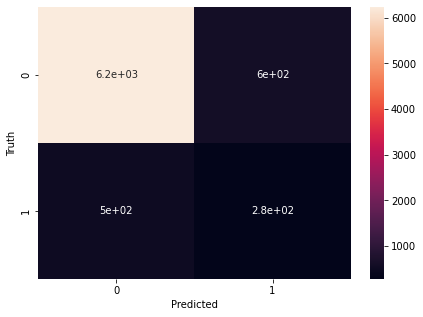

In [266]:
#Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(7,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [267]:
#Print classification report for precesion, recall and f1-score for each classes
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      6840
           1       0.32      0.36      0.34       783

    accuracy                           0.86      7623
   macro avg       0.62      0.64      0.63      7623
weighted avg       0.86      0.86      0.86      7623



According to the analysis conducted, we can conclude that, although our model has quite high accuracy, it predicts minority class not so well. It's confirmed by quite low value of f-score. So, we should conduct additional research  on considered models and find out, is it possivle to maximize f-score somehow to take the final decision.

Let's look at features importance. We use permutation importance, which can be used for different models. It performs better than build-in feature importance from Random Forest, since it's prone to overestimate numeric features.

In [133]:
def permutation_importances(rf, X_train, y_train, metric):
    baseline = metric(X_train, y_train)
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy()
        X_train[col] = np.random.permutation(X_train[col])
        m = metric(X_train, y_train)
        X_train[col] = save
        imp.append(baseline - m)
    return np.array(imp)

imp = permutation_importances(model, oversampled_X_sc, oversampled_Y,
                              model.score)

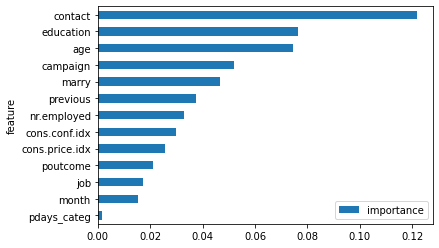

,importance
feature,
contact,0.121708
education,0.076341
age,0.074351
campaign,0.052124
marry,0.046818
previous,0.037294
nr.employed,0.032966
cons.conf.idx,0.030025
cons.price.idx,0.025788


In [188]:
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)
features = oversampled_X_sc.columns
feat_imp = pd.DataFrame(features, columns = ['feature'])
feat_imp['importance'] = imp
feat_imp.sort_values(by = 'importance', ascending = False).reset_index(drop=True)
for i in feat_imp.feature:
    if has_numbers(i):
        result = ''.join([y for y in i if not y.isdigit()])
        feat_imp.feature.replace(i, result, inplace = True)
feat_imp = feat_imp.groupby('feature').agg({'importance': 'mean'}).sort_values(by = 'importance', ascending = False)
#plot = plt.barh(feat_imp.index, feat_imp.importance)
ax = feat_imp.plot(kind="barh")
ax.invert_yaxis()
plt.show()
feat_imp

<h3>References:</h3>

1. 5 Techniques to Handle Imbalanced Data For a Classification Problem, URL: https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/
2. Naive-Bayes for mixed typed data in scikit-learn, URL: https://medium.com/analytics-vidhya/naive-bayes-for-mixed-typed-data-in-scikit-learn-fb6843e241f0
3. Titanic Naive bayes, URL: https://www.kaggle.com/code/guruprasad91/titanic-naive-bayes/notebook
4. Random Forest Feature Importance Computed in 3 Ways with Python, URL: https://mljar.com/blog/feature-importance-in-random-forest/
5. Beware Default Random Forest Importances, URL: https://explained.ai/rf-importance/index.html
6. Bagging and Random Forest for Imbalanced Classification, URL: https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/